# CGC and fishy genes enrichment analysis

* Min processed across methods
* Not normalized
* Shared genes 

In [27]:
import sys
import socket
print("Working node:", socket.gethostname())
sys.path.append('/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/')
from global_variables import *

Working node: bbgn005


In [28]:
import pandas as pd
import math
from matplotlib import pyplot as plt
import os
import numpy as np
import seaborn as sns
from tqdm import tqdm
import warnings
import random
from scipy import stats

## Compute enrichment scores

In [51]:
def processed_by_all(df_pvals):
    """
    Get bolean of vector of genes that are processed by all methods.
    """
    
    not_na = df_pvals.notna().all(1)
    
    return not_na


def enrich_score(vec_labels):
    """
    Compute enrichment score as shown in Martínez-Jiménez et Al. 2020 
    https://www.nature.com/articles/s41568-020-0290-x
    """
    
    target_count = 0
    lst_score = []

    for total_count, bi_label in enumerate(vec_labels):
        target_count += bi_label
        enrich_value = target_count / (total_count + 1)
        lst_score.append(enrich_value)
        
    return np.array(lst_score)


def min_processed_genes(df_pvals, processed_thld=1):
    """
    Define n (n top genes) by integer or equal to the min 
    number of processed genes with p-val < min_score.
    """
                    
    df = df_pvals.copy()
    n = ((df.lt(processed_thld)) & (df.notna())).sum().min()     

    return n


def avg_cut_processed_genes(df, rank_cut, alpha=0.01):
    """
    Get the average number of gemes processed by all the methods.
    """
    
    all_methods_pval = [col for col in df.columns if col.endswith("pval")]
    
    if rank_cut == "processed":
        avg_rank_cut = round(df[all_methods_pval].apply(lambda col: col.notna() & (col != 1)).sum().mean())
        
    elif rank_cut == "significant":
        avg_rank_cut = round(df[all_methods_pval].apply(lambda col: col < alpha).sum().mean())
        
    else:
        raise ValueError("unable to handle the parameter 'rank_cut'. Allowed values are ['min_processed', 'processed', 'significant', int].""")
    
    return avg_rank_cut


def auc(enrich_score_vec):
    """
    Compute AUC of a set ranked enrichment scores 
    as shown in Martínez-Jiménez et Al. 2020 
    https://www.nature.com/articles/s41568-020-0290-x
    """
    
    auc_score = 0
    for i, pi in enumerate(enrich_score_vec):
        score = pi / math.log(i+2, 10)
        auc_score += score
        
    return auc_score


def sort_by_col(df, col):
    """
    Sort by method rank or by annotation to get max score.
    """
    
    if col == "CGC" or col == "Fish":
        ascending=False
    else:
        ascending=True

    return df.copy().sort_values(by = col, ascending=ascending).reset_index(drop = True)


def get_auc(df,
            method, 
            rank_cut, 
            normalize=False, 
            seed=128,
            alpha=0.01,
            min_rank_cut_thld=1):
    """
    Get AUC of the enrichment curve given a the genetable of a method.
    """
   
    if method == "random":
        df_sorted = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    else:
        df_sorted = sort_by_col(df, f"{method}_rank").reset_index(drop=True)
    
    if isinstance(rank_cut, int):
        df_cut_sorted = df_sorted[:rank_cut]
        
    elif isinstance(rank_cut, str):
        
        avg_rank_cut = avg_cut_processed_genes(df_sorted, rank_cut)
        
        if rank_cut == "processed":
            if method == "random":
                df_cut_sorted = df_sorted[:avg_rank_cut] 
            else:
                method_pval = f"{method}_pval"
                df_cut_sorted = df_sorted[(df_sorted[method_pval].notna()) & (df_sorted[method_pval] != 1)]
                
        elif rank_cut == "significant":
            if method == "random":
                avg_rank_cut = avg_cut_processed_genes(df_sorted, rank_cut, alpha=alpha)
                df_cut_sorted = df_sorted[:avg_rank_cut]
            else:
                method_pval = f"{method}_pval"
                df_cut_sorted = df_sorted[df_sorted[method_pval] < alpha]
                
        else:
            raise ValueError("unable to handle the parameter 'rank_cut'. Allowed values are ['min_processed', 'processed', 'significant', int].""")
            
        if method == "random":
            if avg_rank_cut < min_rank_cut_thld:
                return None, None
    
    df_cut_sorted = df_cut_sorted[["CGC", "Fish"]]
    cgc_auc = auc(enrich_score(df_cut_sorted["CGC"]))
    fish_auc = auc(enrich_score(df_cut_sorted["Fish"]))
    
    if not normalize:
        return cgc_auc, fish_auc
    
    else:
        df_max_cgc = sort_by_col(df_cut_sorted, "CGC")
        df_max_fish = sort_by_col(df_cut_sorted, "Fish")
        cgc_max_auc = auc(enrich_score(df_max_cgc["CGC"]))
        fish_max_auc = auc(enrich_score(df_max_fish["Fish"]))
        
        if cgc_max_auc == 0:
            cgc_auc_norm = np.nan
        else:
            cgc_auc_norm = cgc_auc / cgc_max_auc
        if fish_max_auc == 0:
            fish_auc_norm = np.nan
        else:
            fish_auc_norm = fish_auc / fish_max_auc

        return cgc_auc_norm, fish_auc_norm
    
    
def get_auc_cohort(df_cohort, 
                   lst_methods, 
                   normalize=False, 
                   seed=128, 
                   min_rank_cut_thld=1, 
                   processed_thld=1,
                   rank_cut="min_processed",
                   alpha=0.01,
                   rnd_iter=25):

    """
    Get CGC and Fish enrichment AUC for each method.
    """

    col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
    min_processed = min_processed_genes(df_cohort[col_pvals], processed_thld=processed_thld)
    
    if isinstance(rank_cut, str):
        if rank_cut == "min_processed":
            rank_cut = min_processed
    elif isinstance(rank_cut, int):
        if rank_cut < min_processed:
            rank_cut = min_processed

    lst_cols = ["Rank_cut"]
    lst_aucs = [rank_cut]
    
    if isinstance(rank_cut, int):
        if rank_cut < min_rank_cut_thld:
            return 
    
    for method in lst_methods:
        
        if method == "random":
            
            rnd_cgc_lst = []
            rnd_fish_lst = []

            # Generate a list of random integers
            random.seed(seed)
            lst_seeds = [random.randint(1, 1000) for _ in range(rnd_iter)]
            
            for i in range(rnd_iter):
                
                cgc_auc, fish_auc = get_auc(df_cohort, 
                                            method, 
                                            rank_cut=rank_cut, 
                                            normalize=normalize, 
                                            seed=lst_seeds[i], 
                                            min_rank_cut_thld=min_rank_cut_thld,
                                            alpha=alpha)
                
                # AUC scores will be None if the cut thld is not met
                if cgc_auc is None or fish_auc is None:
                    return
                
                else:
                    rnd_cgc_lst.append(cgc_auc)
                    rnd_fish_lst.append(fish_auc)                    
                    
            # Append mean and CI
            cgc_auc_mean, cgc_auc_ci_low, cgc_auc_ci_up = get_mean_ci(rnd_cgc_lst)
            fish_auc_mean, fish_auc_ci_low, fish_auc_ci_up = get_mean_ci(rnd_fish_lst)
            [lst_cols.append(f"{method}_{col}_auc") for col in ["CGC", "Fish"]]
            [lst_aucs.append(value) for value in [cgc_auc_mean, fish_auc_mean]]
            
            [lst_cols.append(f"{method}_{col}_auc") for col in ["CGC_ci_low", "CGC_ci_up", "Fish_ci_low", "Fish_ci_up"]]
            [lst_aucs.append(value) for value in [cgc_auc_ci_low, cgc_auc_ci_up, 
                                                  fish_auc_ci_low, fish_auc_ci_up]]
        
        else:
            cgc_auc, fish_auc = get_auc(df_cohort, 
                                        method, 
                                        rank_cut=rank_cut, 
                                        normalize=normalize, 
                                        seed=seed, 
                                        min_rank_cut_thld=min_rank_cut_thld,
                                        alpha=alpha)
        
            # AUC scores will be None if the cut thld is not met
            if cgc_auc is None or fish_auc is None:
                return

            else:
                [lst_cols.append(f"{method}_{col}_auc") for col in ["CGC", "Fish"]]
                [lst_aucs.append(value) for value in [cgc_auc, fish_auc]]

    return pd.DataFrame([lst_aucs], columns=lst_cols)


def get_auc_genetable(df_genetable, 
                      lst_methods, 
                      normalize=False, 
                      genes_overlap=True, 
                      seed=128, 
                      min_rank_cut_thld=1,
                      processed_thld=1,
                      alpha=0.01,
                      rank_cut="min_processed",
                      rnd_iter=25):
    """
    Get CGC and Fish enrichment AUC score for each method (cols) and each cohort (rows).
    """
    
    df_genetable = df_genetable.copy()
    
    # Get only overlapping genes or overlapping genes with a pval < 1
    col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
    if genes_overlap == True:    
        not_na = processed_by_all(df_genetable[col_pvals])
        df_genetable = df_genetable[not_na]
    elif genes_overlap == "pval_less_than_one":
        df_genetable = df_genetable[~((df_genetable[col_pvals] == 1) | df_genetable[col_pvals].isna()).any(axis=1)]
    
    lst_results = []
    for cohort, df_cohort in tqdm(df_genetable.groupby("Cohort")):
 
        auc_cohort = get_auc_cohort(df_cohort.reset_index(drop=True), 
                                    lst_methods, 
                                    normalize=normalize, 
                                    seed=seed,
                                    min_rank_cut_thld=min_rank_cut_thld,
                                    processed_thld=processed_thld,
                                    rank_cut=rank_cut,
                                    alpha=alpha,
                                    rnd_iter=rnd_iter)
        
        if auc_cohort is not None:
            auc_cohort.insert(0, "Cohort", cohort)
            lst_results.append(auc_cohort)
        
    return pd.concat(lst_results).reset_index(drop=True)


def get_mean_ci(lst):
    
    mean = np.mean(lst)
    
    if all(x == lst[0] for x in lst):
        
        return mean, mean, mean
    
    else:
        sem = stats.sem(lst)
        level = 0.95

        # Calculate the 95% confidence interval
        ci = stats.t.interval(0.95, len(lst) - 1, loc=mean, scale=stats.sem(lst))
    
        return mean, ci[0], ci[1]

## Plots

In [59]:
def ema_smooth(scalars: list[float], weight: float) -> list[float]:
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    
    NB: copied from stack-overflow
    """
    
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed


def get_zorder(col):
    """
    Prioritize order of the clustering methods
    """
    
    if col.split("_")[0] == "o3d":
        zorder = 3
    elif col.split("_")[0] == "hotmaps":
        zorder = 2
    elif col.split("_")[0] == "clustl":
        zorder = 1
    else:
        zorder = 0
        
    return zorder


def plot_auc_summary(auc_df, names_dic, colors_dic, 
                     title = "AUC summary",
                     smooth = False, 
                     ema_w = 0.7, 
                     figsize = (20, 10), 
                     legend_fontsize = 12, 
                     legend_ncol = 1,
                     legend_frame=True,
                     plot_xticks=False,
                     extract_cancer=False,
                     style="o-",
                     legend_bbox=(1, 1),
                     legend_outside=False,
                     zero_hline=False,
                     rm_zero_rows=True,
                     filename="auc_summary.png",
                     clustering_labels_only=False
                     ):
    """
    Plot AUCs enrichment scores for each chorts sorted by average AUC across methods.
    """
    
    auc_df = auc_df.copy()
    others_label = 1
    
    if rm_zero_rows:
        auc_df = auc_df[~(auc_df.drop(columns=["Cohort"]) == 0).all(axis=1)]
    
    if extract_cancer:
        auc_df["Cohort"] = auc_df["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
    auc_df["Avg"] = auc_df.mean(numeric_only=True, axis=1)
    auc_df = auc_df.sort_values("Avg", ascending=False)
    auc_df = auc_df.drop(columns=["Avg"])
    auc_df = auc_df.set_index("Cohort")
    
    # Sort cols by average score
    col_order = auc_df.mean(numeric_only=True).sort_values(ascending=False).index
    auc_df = auc_df[col_order]

    # Plot
    plt.figure(figsize = figsize)
    if zero_hline:
        plt.axhline(y=0, color='pink', linestyle='--', zorder=-1)       # alt lightcoral
        
    for i, col in enumerate(auc_df.columns):
        method_name = names_dic[col.split("_")[0]]
    
        if smooth:
            x = ema_smooth(auc_df[col], ema_w)
        else: 
            x = auc_df[col]
    
        col_split = col.split("_")
        if col_split[2] == "ci":
            x_mean = auc_df[f"random_{col_split[1]}_auc"]
            index = x_mean.index
            if smooth:
                x_mean = ema_smooth(x_mean, ema_w)
                
            if col_split[3] == "low":
                label="Random 95% CI"
            else:
                label=None
            plt.fill_between(index, x, x_mean, color=colors_dic[method_name], alpha=0.2, zorder=0, label=label)
            
        else:
            if smooth:
                x = ema_smooth(auc_df[col], ema_w)
            else: 
                x = auc_df[col]
            if clustering_labels_only:
                if method_name in ["HotMAPS", "Oncodrive3D", "OncodriveCLUSTL", "Random"]:
                    label = f"{method_name} (μ = {auc_df[col].mean():.4})"
                else:
                    if others_label:
                        label = f"Other methods"
                        others_label = 0
                    else:
                        label = None
            else:
                label = label = f"{method_name} (μ = {auc_df[col].mean():.4})"
            plt.plot(x, style, color = colors_dic[method_name], 
                     label = label, 
                     zorder=get_zorder(col))

    if plot_xticks:    
        plt.xticks(rotation=45, rotation_mode="anchor", ha='right') 
    else:
        plt.xticks([])

    plt.ylabel("AUC", fontsize = 16)
    plt.xlabel("Cohort", fontsize = 16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize = 16)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()

    if legend_outside:
        plt.legend(handles, labels, fontsize=legend_fontsize, ncol=legend_ncol,
                   bbox_to_anchor=legend_bbox, frameon=False)
    else:
        plt.legend(fontsize = legend_fontsize, ncol = legend_ncol, frameon=False)
        
    if legend_frame == False:
        legend = plt.gca().get_legend()
        legend.set_frame_on(False)
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    

def diff_to_random(df):
    """
    Get the difference between the score of each method and random (last) ranking.
    """
    
    df = df.copy()
    cohorts = df.pop("Cohort")
    diff = df.iloc[:, :-1].sub(df.iloc[:, -1], axis=0)
    
    return pd.concat((cohorts, diff), axis=1)


def cols_to_plot(lst_methods, enrich_target="CGC", auc=True):
    
    if auc:
        metric="auc"
    else:
        metric="enrich"
    lst = ["Cohort"] + [f"{method}_{enrich_target}_{metric}" for method in lst_methods]
    
    if "random" in lst_methods:
        
        return lst + [f"random_{enrich_target}_ci_low_{metric}", f"random_{enrich_target}_ci_up_{metric}"]
    
    else:
        
        return lst

### Enrichment example one TCGA cohort

In [46]:
def plot_enrich_score_simple(auc_df, names_dic, colors_dic, 
                      title = "Enrichment score",
                      smooth = False, 
                      ema_w = 0.9, 
                      figsize = (20, 10), 
                      legend_fontsize = 12, 
                      legend_ncol = 1,
                      legend_frame=True,
                      style="o-",
                      legend_bbox=(1, 1),
                      legend_outside=False,
                      zero_hline=False,
                      ):
    """
    Plot AUCs enrichment scores for each chorts sorted by average AUC across methods.
    """
    
    auc_df = auc_df.copy()
    
    # Sort cols by average score
    col_order = auc_df.mean(numeric_only=True).sort_values(ascending=False).index
    auc_df = auc_df[col_order]

    # Plot
    plt.figure(figsize = figsize)
    if zero_hline:
        plt.axhline(y=0, color='pink', linestyle='--', zorder=-1)       # alt lightcoral
        
    for col in auc_df.columns:
        method_name = names_dic[col.split("_")[0]]
        if smooth:
            x = ema_smooth(auc_df[col], ema_w)
        else: 
            x = auc_df[col]
        plt.plot(x, 
                 style, 
                 color = colors_dic[method_name], 
                 label = f"{method_name} (Avg = {auc_df[col].mean():.4})", 
                 zorder=get_zorder(col))

    plt.ylabel("Enrichment score", fontsize = 13)
    plt.xlabel("Rank", fontsize = 13)
    plt.title(title, fontsize = 15)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()

    if legend_outside:
        plt.legend(handles, labels, fontsize=legend_fontsize, ncol=legend_ncol,
                   bbox_to_anchor=legend_bbox)
    else:
        plt.legend(fontsize = legend_fontsize, ncol = legend_ncol)
        
    if legend_frame == False:
        legend = plt.gca().get_legend()
        legend.set_frame_on(False)
    plt.show()


def plot_enrich_score(auc_df, names_dic, colors_dic, 
                      title = "Enrichment score",
                      smooth = False, 
                      ema_w = 0.9, 
                      figsize = (20, 10), 
                      legend_fontsize = 12, 
                      legend_ncol = 1,
                      legend_frame=True,
                      style="o-",
                      legend=True,
                      legend_bbox=(1, 1),
                      legend_outside=False,
                      zero_hline=False,
                      filename="fig.png",
                      xlim=None,
                      ylim=0):
    """
    Plot AUCs enrichment scores for each chorts sorted by average AUC across methods.
    """
    
    auc_df = auc_df.copy()
    
    # Sort cols by average score
    
    if "Cohort" in auc_df.columns:
        auc_df = auc_df.drop(columns=["Cohort"])
    col_order = auc_df.mean(numeric_only=True).sort_values(ascending=False).index
    col_order = auc_df.apply(lambda x: auc(x), axis=0).sort_values(ascending=False).index
    auc_df = auc_df[col_order]

    # Plot
    plt.figure(figsize = figsize)
    if zero_hline:
        plt.axhline(y=0, color='pink', linestyle='--', zorder=-1)       # alt lightcoral
        
    for col in auc_df.columns:
        method_name = names_dic[col.split("_")[0]]
        if smooth:
            x = ema_smooth(auc_df[col], ema_w)
        else: 
            x = auc_df[col]

        col_split = col.split("_")
        if col_split[2] == "ci":
            x_mean = auc_df[f"random_{col_split[1]}_enrich"]
            index = x_mean.index
            if smooth:
                x_mean = ema_smooth(x_mean, ema_w)
            if col_split[3] == "low":
                label="Random 95% CI"
            else:
                label=None
            #plt.plot(x, "--", color=colors_dic[method_name], zorder=0, label=label)    
            plt.fill_between(index, x, x_mean, color=colors_dic[method_name], alpha=0.2, zorder=0, label=label)
            
        else:
            if smooth:
                x = ema_smooth(auc_df[col], ema_w)
            else: 
                x = auc_df[col]
            #plt.plot(x, style, color = colors_dic[method_name], label = f"{method_name} (wAUC = ≈{int(np.round(auc(auc_df[col])))})", zorder=get_zorder(col))
            plt.plot(x, style, color = colors_dic[method_name], label = f"{method_name} (AUC = {np.round(auc(auc_df[col]), 2)})", zorder=get_zorder(col))

    plt.ylabel("Enrichment score", fontsize = 16)
    plt.xlabel("Rank", fontsize = 16)
    plt.title(title, fontsize = 16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.ylim(ylim)
    plt.xlim(xlim)
    
    # Legend
    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()

        if legend_outside:
            plt.legend(handles, labels, fontsize=legend_fontsize, ncol=legend_ncol,
                       bbox_to_anchor=legend_bbox, frameon=False)
        else:
            plt.legend(fontsize = legend_fontsize, ncol = legend_ncol, frameon=False)

        if legend_frame == False:
            legend = plt.gca().get_legend()
            legend.set_frame_on(False)

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def get_enrich(df,
               method, 
               rank_cut, 
               normalize=False, 
               seed=128):
    """
    Get AUC of the enrichment curve given a the genetable of a method.
    """
    
    if method == "random":
        df_sorted = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    else:
        df_sorted = sort_by_col(df, f"{method}_rank").reset_index(drop=True)
    
    df_cut_sorted = df_sorted[:rank_cut]
    cgc_score = enrich_score(df_cut_sorted["CGC"])
    fish_score = enrich_score(df_cut_sorted["Fish"])
    
    if not normalize:
        
        return cgc_score, fish_score
    
    else:
        df_max_cgc = sort_by_col(df_cut_sorted, "CGC")
        df_max_fish = sort_by_col(df_cut_sorted, "Fish")
        cgc_max_score = enrich_score(df_max_cgc["CGC"])
        fish_max_score = enrich_score(df_max_fish["Fish"])
        
        cgc_score_norm = cgc_score / cgc_max_score
        fish_score_norm = fish_score / fish_max_score

        return cgc_score_norm, fish_score_norm
    
    
def get_enrich_cohort(df_cohort, 
                      lst_methods, 
                      normalize=False, 
                      seed=128, 
                      min_rank_cut_thld=1, 
                      processed_thld=1,
                      rnd_iter=25):

    """
    Get CGC and Fish enrichment AUC for each method.
    """

    col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
    min_processed = min_processed_genes(df_cohort[col_pvals], processed_thld=processed_thld)

    lst_cols = []
    lst_scores = []
    
    if min_processed >= min_rank_cut_thld:
        for method in lst_methods:
            
            if method == "random":
                
                rnd_cgc_lst = []
                rnd_fish_lst = []

                # Generate a list of random integers
                random.seed(seed)
                lst_seeds = [random.randint(1, 1000) for _ in range(rnd_iter)]

                for i in range(rnd_iter):
                    
                    cgc_score, fish_score = get_enrich(df_cohort, 
                                                       method, 
                                                       rank_cut=min_processed, 
                                                       normalize=normalize, 
                                                       seed=lst_seeds[i])   
                    rnd_cgc_lst.append(cgc_score)
                    rnd_fish_lst.append(fish_score)   
                
                ## CGC
                df = pd.DataFrame(rnd_cgc_lst).T         # Rows are ranks and cols are iterations
                cgc_mean_lst = []
                cgc_ci_up_lst = []
                cgc_ci_low_lst = []

                for i in range(len(df)):
                    cgc_score_mean, cgc_score_ci_low, cgc_score_ci_up = get_mean_ci(df.iloc[i,:])
                    cgc_mean_lst.append(cgc_score_mean)
                    cgc_ci_low_lst.append(cgc_score_ci_low)
                    cgc_ci_up_lst.append(cgc_score_ci_up)
                    
                ## Fishy
                df = pd.DataFrame(rnd_fish_lst).T
                fish_mean_lst = []
                fish_ci_up_lst = []
                fish_ci_low_lst = []

                for i in range(len(df)):
                    fish_score_mean, fish_score_ci_low, fish_score_ci_up = get_mean_ci(df.iloc[i,:])
                    fish_mean_lst.append(fish_score_mean)
                    fish_ci_low_lst.append(fish_score_ci_low)
                    fish_ci_up_lst.append(fish_score_ci_up)
                
                [lst_cols.append(f"{method}_{col}_enrich") for col in ["CGC", "Fish"]]
                [lst_scores.append(value) for value in [cgc_mean_lst, fish_mean_lst]]
                
                [lst_cols.append(f"{method}_{col}_enrich") for col in ["CGC_ci_low", "CGC_ci_up", "Fish_ci_low", "Fish_ci_up"]]
                [lst_scores.append(value) for value in [cgc_ci_low_lst, cgc_ci_up_lst, 
                                                        fish_ci_low_lst, fish_ci_up_lst]]
        
            else:
                
                cgc_score, fish_score = get_enrich(df_cohort, method, rank_cut=min_processed, normalize=normalize, seed=seed)
                [lst_cols.append(f"{method}_{col}_enrich") for col in ["CGC", "Fish"]]
                [lst_scores.append(value) for value in [cgc_score, fish_score]]

        return pd.DataFrame({col : scores for col, scores in zip(lst_cols, lst_scores)})

In [32]:
genetable_path = f"/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/data/results/{SUBDIR}/{RUN}.genetable.tsv"
genetable = pd.read_csv(genetable_path, sep="\t", dtype={1 : str, 2 : str, 3 : int})

lst_methods = ["o3d", "hotmaps", "clustl"] 
cohort = "TCGA_WXS_BRCA"

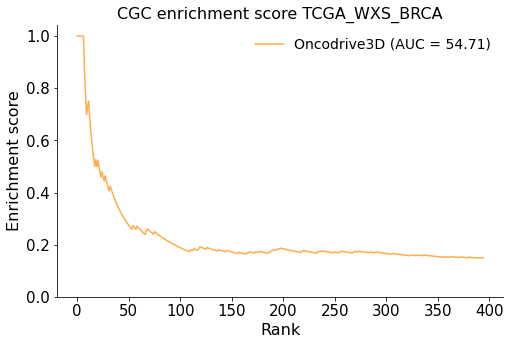

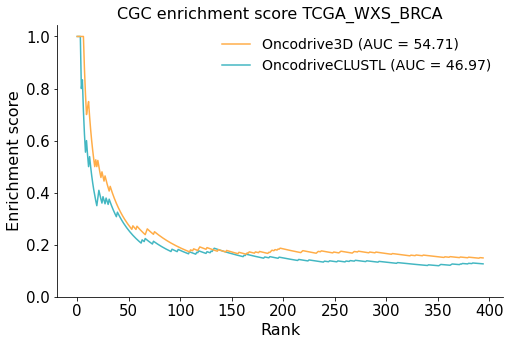

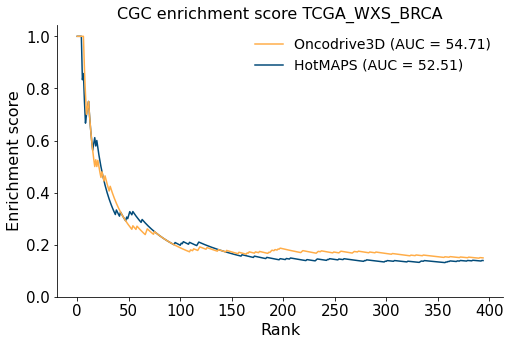

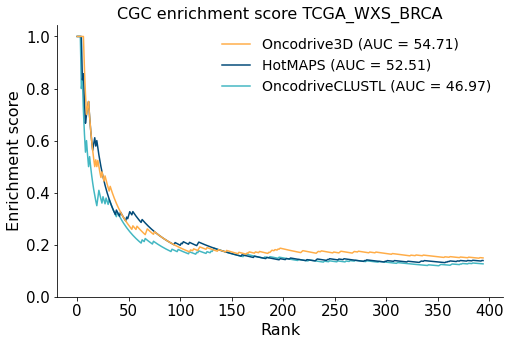

In [7]:
genetable_cohort = genetable[genetable["Cohort"] == cohort]
methods_pval_names = [f"{method}_pval" for method in lst_methods if method != "random"]

col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
min_processed = min_processed_genes(genetable_cohort[col_pvals])

not_na = genetable_cohort[methods_pval_names].notna().all(1)
genetable_cohort = genetable_cohort[not_na]

df_enrich = get_enrich_cohort(genetable_cohort, 
                            lst_methods, 
                            normalize=False, 
                            seed=128, 
                            min_rank_cut_thld=1, 
                            processed_thld=1)
df_enrich.insert(0, "Cohort", cohort)

enrich_target = "CGC"
lst_methods = ["o3d"] 
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
                  # filename=f'plots/enrichment_cgc_{cohort}_o3d.png'
                  filename=None)

lst_methods = ["o3d", "clustl"] 
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
                  # filename=f'plots/enrichment_cgc_{cohort}_o3d_clustl.png',
                  filename=None)

lst_methods = ["o3d", "hotmaps"] 
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
                  # filename=f'plots/enrichment_cgc_{cohort}_o3d_hotmaps.png'
                  filename=None)

lst_methods = ["o3d", "hotmaps", "clustl"] 
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
                  # filename=f'plots/enrichment_cgc_{cohort}_clustering.png',
                  filename=None)

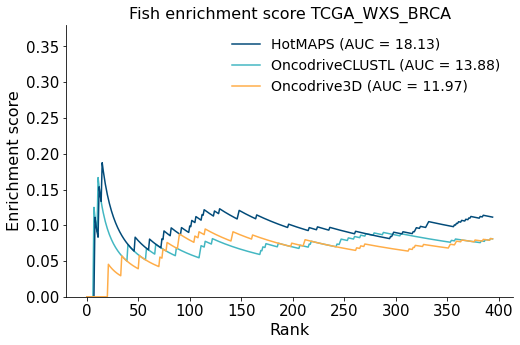

In [8]:
enrich_target = "Fish"
lst_methods = ["o3d", "hotmaps", "clustl"]
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
                  ylim=(0, 0.38),
                  legend=True,
                  # filename=f'plots/enrichment_fishy_{cohort}_clustering.png'
                  filename=None)

#### All methods

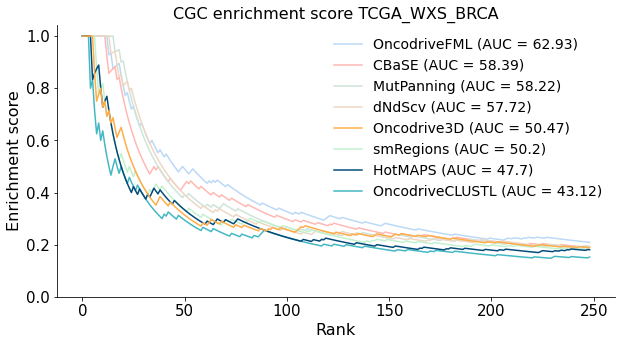

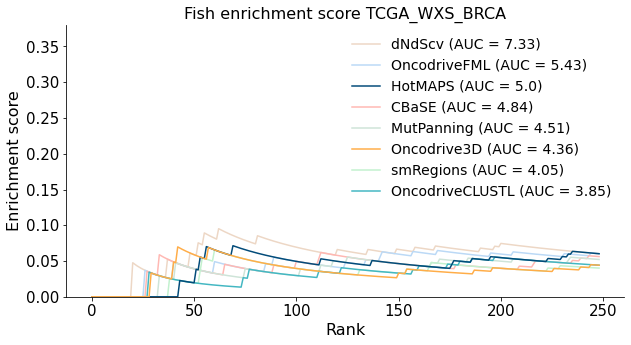

In [58]:
lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]
cohort = "TCGA_WXS_BRCA"

genetable_cohort = genetable[genetable["Cohort"] == cohort]
methods_pval_names = [f"{method}_pval" for method in lst_methods if method != "random"]

col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
min_processed = min_processed_genes(genetable_cohort[col_pvals])

not_na = genetable_cohort[methods_pval_names].notna().all(1)
genetable_cohort = genetable_cohort[not_na]

df_enrich = get_enrich_cohort(genetable_cohort, 
                            lst_methods, 
                            normalize=False, 
                            seed=128, 
                            min_rank_cut_thld=1, 
                            processed_thld=1)
df_enrich.insert(0, "Cohort", cohort)

enrich_target = "CGC"
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (10, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
                  filename=f'plots/enrichment_cgc_{cohort}.png')


enrich_target = "Fish"
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (10, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
                  ylim=(0, 0.38),
                  legend=True,
                  filename=f'plots/enrichment_fishy_{cohort}.png')

### Enrichment explanatory example

In [38]:
genes_toy = ["PTEN", "KRAS", "TP53", "RBM39", "PIK3CA", "OR10T2", "PPP2R1A", "BCOR", "FBXW7", "SOS1"]
cgc_toy = [1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
fishy_toy = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
pval_toy= np.zeros(len(genes_toy))
genetable_toy = pd.DataFrame({"Gene" : genes_toy,
                              "CGC" : cgc_toy,
                              "Fish" : fishy_toy,
                              "o3d_pval" : pval_toy,
                              "o3d_rank" : range(len(genes_toy))})
genetable_toy

,Gene,CGC,Fish,o3d_pval,o3d_rank
0,PTEN,1,0,0.0,0
1,KRAS,1,0,0.0,1
2,TP53,1,0,0.0,2
3,RBM39,0,0,0.0,3
4,PIK3CA,1,0,0.0,4
5,OR10T2,0,1,0.0,5
6,PPP2R1A,1,0,0.0,6
7,BCOR,1,0,0.0,7
8,FBXW7,1,0,0.0,8
9,SOS1,0,0,0.0,9


In [39]:
df_enrich = get_enrich_cohort(genetable_toy, 
                              lst_methods=["o3d"], 
                              normalize=False, 
                              seed=128, 
                              min_rank_cut_thld=1, 
                              processed_thld=1)
df_enrich.insert(0, "Cohort", cohort)
df_enrich

,Cohort,o3d_CGC_enrich,o3d_Fish_enrich
0,TCGA_WXS_BRCA,1.000000,0.000000
1,TCGA_WXS_BRCA,1.000000,0.000000
2,TCGA_WXS_BRCA,1.000000,0.000000
3,TCGA_WXS_BRCA,0.750000,0.000000
4,TCGA_WXS_BRCA,0.800000,0.000000
5,TCGA_WXS_BRCA,0.666667,0.166667
6,TCGA_WXS_BRCA,0.714286,0.142857
7,TCGA_WXS_BRCA,0.750000,0.125000
8,TCGA_WXS_BRCA,0.777778,0.111111
9,TCGA_WXS_BRCA,0.700000,0.100000


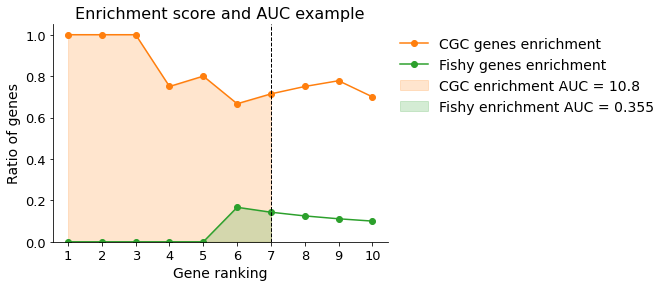

In [41]:
N=7
auc_df=df_enrich#[enrich_cols]
smooth = False
ema_w = 0.9
figsize = (6, 4)
#figsize = (5, 3.5)
legend_fontsize = 14
legend_ncol = 1
legend_frame=False
style="o-"
legend_bbox=(1, 1)
legend_outside=True

#=====
# Plot

auc_df = auc_df.copy()
if "Cohort" in auc_df.columns:
    auc_df = auc_df.drop(columns=["Cohort"])
    
cgc_vec = auc_df[:N]["o3d_CGC_enrich"].values
auc_cgc = auc(cgc_vec)    
fish_vec = auc_df[:N]["o3d_Fish_enrich"].values
auc_fish = auc(fish_vec)    

# Plot
plt.figure(figsize = figsize)

x = auc_df["o3d_CGC_enrich"]
x.index = x.index+1
plt.plot(x, style, color = "#FF7F0E", label = f"CGC genes enrichment")
plt.fill_between(range(1, N+1), x[:N], np.repeat(0, N), color="#FF7F0E", alpha=0.2, label = f"CGC enrichment AUC = {auc_cgc:.3}")

x = auc_df["o3d_Fish_enrich"]
x.index = x.index+1
plt.plot(x, style, color = "#2CA02C", label = f"Fishy genes enrichment")
plt.fill_between(range(1, N+1), x[:N], np.repeat(0, N), color="#2CA02C", alpha=0.2, label = f"Fishy enrichment AUC = {auc_fish:.3}")

plt.axvline(x = N, color = 'black', ls="--", lw=1)#, label = f'N = {N}')

plt.ylabel("Ratio of genes", fontsize = 14)
plt.xlabel("Gene ranking", fontsize = 14)
plt.ylim(0, 1.05)
plt.xticks(range(1, len(auc_df)+1), fontsize=13)
plt.yticks( fontsize=13)
plt.title("Enrichment score and AUC example", fontsize = 16)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Legend
handles, labels = plt.gca().get_legend_handles_labels()

if legend_outside:
    plt.legend(handles, labels, fontsize=legend_fontsize, ncol=legend_ncol,
               bbox_to_anchor=legend_bbox)
else:
    plt.legend(fontsize = legend_fontsize, ncol = legend_ncol)

if legend_frame == False:
    legend = plt.gca().get_legend()
    legend.set_frame_on(False)
plt.savefig('plots/enrichment_example.png', dpi=300, bbox_inches='tight')
plt.show()

## AUC

In [52]:
# Load
datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
intogen_output = f"{datasets}/output/cancer_202404/intogen_output"
genetable_path = f"/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/data/results/{SUBDIR}/{RUN}.genetable.tsv"

genetable = pd.read_csv(genetable_path, sep="\t", dtype={1 : str, 2 : str, 3 : int})
genetable_noicgc = genetable[[not cohort.startswith("ICGC") for cohort in genetable["Cohort"]]].reset_index(drop=True)
genetable_subset = genetable[genetable["Cohort"].str.startswith("TCGA")]

In [53]:
df_auc = get_auc_genetable(genetable_subset, 
                           lst_methods,
                           normalize=False, 
                           genes_overlap=True, 
                           min_rank_cut_thld=5,
                           processed_thld=1)
df_auc

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 75.01it/s]


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc,smreg_CGC_auc,smreg_Fish_auc,cbase_CGC_auc,cbase_Fish_auc,dndscv_CGC_auc,dndscv_Fish_auc,mutpan_CGC_auc,mutpan_Fish_auc,fml_CGC_auc,fml_Fish_auc
0,TCGA_WXS_AML,16,17.704906,0.050794,17.088391,0.106160,18.886389,0.166894,12.768888,0.489083,17.691090,1.343610,18.545617,0.308819,18.237290,0.600194,18.874639,0.393058
1,TCGA_WXS_BLCA,572,65.222506,6.798820,68.281979,9.556961,67.448847,6.327770,66.064501,10.614911,90.678907,7.054786,92.783919,10.271528,90.557444,9.868916,90.835441,7.765199
2,TCGA_WXS_BRCA,249,50.472669,4.357805,47.699594,5.001236,43.117311,3.849829,50.197986,4.049919,58.385682,4.840115,57.715902,7.325669,58.218827,4.505811,62.932845,5.432454
3,TCGA_WXS_CCRCC,52,28.672082,1.752628,24.828248,1.085799,9.437842,4.276125,18.873501,1.090807,24.602557,3.047323,24.129004,3.807305,25.503495,3.129186,24.621623,1.514691
4,TCGA_WXS_CESC,70,25.289146,2.698525,29.269151,3.466520,25.820857,0.770489,20.295809,1.372874,31.587975,1.209111,34.318186,1.983080,33.678538,1.846362,34.678662,0.191572
5,TCGA_WXS_COADREAD,324,53.310933,13.178952,58.983005,14.032016,61.061946,16.791357,50.200786,11.410036,61.867852,12.135751,63.010154,17.845523,66.736163,13.074035,62.578146,12.358588
6,TCGA_WXS_DLBCLNOS,9,5.787397,0.400292,6.142800,0.242105,8.298651,0.400292,10.804127,0.854527,10.189439,1.212196,12.782109,0.400292,12.525089,0.400292,8.230163,1.212196
7,TCGA_WXS_ESCA,54,21.956818,0.478400,22.747313,0.537380,19.067347,0.520411,15.974785,0.381105,22.418244,0.147081,21.513721,0.549171,23.792878,0.055824,21.895448,0.010641
8,TCGA_WXS_GBM,132,32.695755,3.734477,34.921664,3.203642,32.442300,3.358083,32.309939,1.588255,38.088710,5.459374,37.174267,6.362140,42.615854,3.971194,36.485910,4.910563
9,TCGA_WXS_HCC,184,27.446062,9.463418,31.614604,6.302804,22.164705,11.238300,22.289244,11.049304,33.440427,10.981599,32.715268,21.534263,37.142724,14.822616,28.109178,15.428050


In [54]:
df_auc_fish = df_auc[cols_to_plot(lst_methods, "Fish")]
df_auc_fish[df_auc_fish.isna().any(1)]

,Cohort,o3d_Fish_auc,hotmaps_Fish_auc,clustl_Fish_auc,smreg_Fish_auc,cbase_Fish_auc,dndscv_Fish_auc,mutpan_Fish_auc,fml_Fish_auc


In [55]:
df_auc_cgc

,Cohort,o3d_CGC_auc,hotmaps_CGC_auc,clustl_CGC_auc
0,TCGA_WXS_AML,17.929711,19.024806,20.085070
1,TCGA_WXS_BLCA,76.392748,76.863604,72.334296
2,TCGA_WXS_BRCA,54.714307,52.508392,46.968982
3,TCGA_WXS_CCRCC,29.596534,29.953950,14.086437
4,TCGA_WXS_CESC,33.298150,37.089688,29.260559
5,TCGA_WXS_CHOL,7.578274,9.537550,8.626226
6,TCGA_WXS_COADREAD,59.016169,66.146447,64.070825
7,TCGA_WXS_DLBCLNOS,5.277537,10.019198,15.941080
8,TCGA_WXS_ESCA,25.653995,29.445736,20.151555
9,TCGA_WXS_GBM,38.226869,43.487168,36.672300


#### Clustering methods

In [56]:
# Clustering methods
# ==================

lst_methods=["o3d", "hotmaps", "clustl"]

# Subset cohorts
df_auc = get_auc_genetable(genetable_subset, 
                           lst_methods,
                           normalize=False, 
                           genes_overlap=True, 
                           min_rank_cut_thld=5,
                           processed_thld=1)

df_auc_cgc = df_auc[cols_to_plot(lst_methods, "CGC")]
df_auc_cgc = df_auc_cgc[~df_auc_cgc.isna().any(1)]
df_auc_fish = df_auc[cols_to_plot(lst_methods, "Fish")]
df_auc_fish = df_auc_fish[~df_auc_fish.isna().any(1)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 101.44it/s]


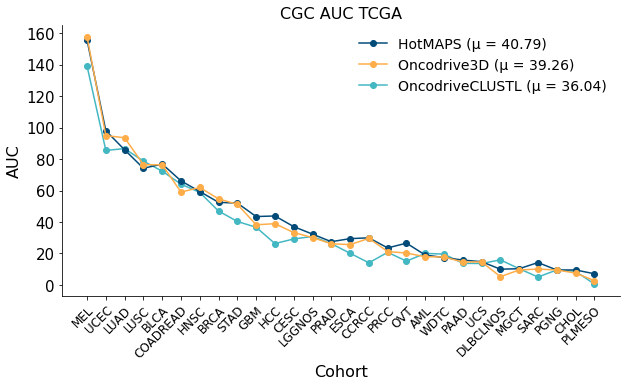

In [57]:
plot_auc_summary(df_auc_cgc, names_dict, colors_dict, 
                 title = "CGC AUC TCGA", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, plot_xticks = True, 
                 extract_cancer=True, legend_outside=True, 
                 # filename="plots/cgc_auc_tcga_clust.png",
                 filename=None)

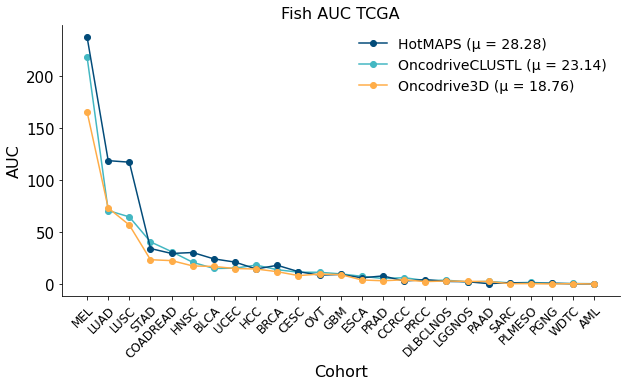

In [16]:
plot_auc_summary(df_auc_fish, names_dict, colors_dict, 
                 title = "Fish AUC TCGA", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, plot_xticks = True, 
                 extract_cancer=True, legend_outside=True, 
                 # filename="plots/fishy_auc_tcga_clust.png"),
                 filename=None

In [17]:
# All cohorts
df_auc = get_auc_genetable(genetable, 
                           lst_methods,
                           normalize=False, 
                           genes_overlap=True, 
                           min_rank_cut_thld=5,
                           processed_thld=1)

df_auc_cgc = df_auc[cols_to_plot(lst_methods, "CGC")]
df_auc_cgc = df_auc_cgc[~df_auc_cgc.isna().any(1)]
df_auc_fish = df_auc[cols_to_plot(lst_methods, "Fish")]
df_auc_fish = df_auc_fish[~df_auc_fish.isna().any(1)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 310.01it/s]


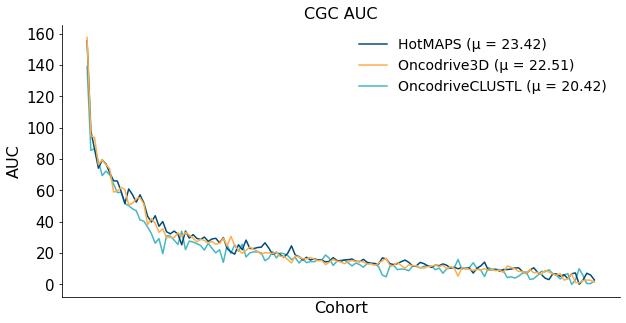

In [18]:
plot_auc_summary(df_auc_cgc, names_dict, colors_dict, title = "CGC AUC", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, 
                 plot_xticks = False, extract_cancer=False, legend_outside=True, style="-",
                 # filename="plots/cgc_auc_clust.png",
                 filename=None)

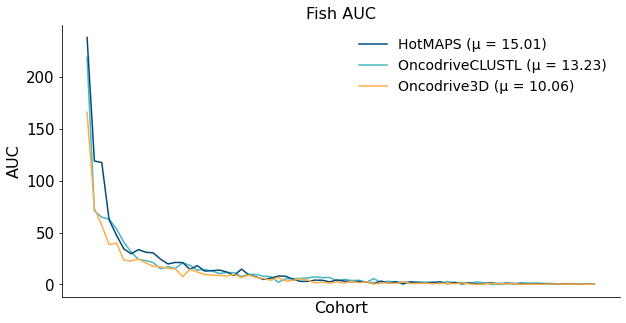

In [19]:
plot_auc_summary(df_auc_fish, names_dict, colors_dict, title = "Fish AUC", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, 
                 plot_xticks = False, extract_cancer=False, legend_outside=True, style="-",
                 # filename="plots/fishy_auc_clust.png",
                 filename=None)

#### All methods

In [65]:
# All methods
# ===========

lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]

# Subset cohorts
df_auc = get_auc_genetable(genetable_subset, 
                           lst_methods,
                           normalize=False, 
                           genes_overlap=True, 
                           min_rank_cut_thld=5,
                           processed_thld=1)

df_auc_cgc = df_auc[cols_to_plot(lst_methods, "CGC")]
df_auc_cgc = df_auc_cgc[~df_auc_cgc.isna().any(1)]
df_auc_fish = df_auc[cols_to_plot(lst_methods, "Fish")]
df_auc_fish = df_auc_fish[~df_auc_fish.isna().any(1)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 55.45it/s]


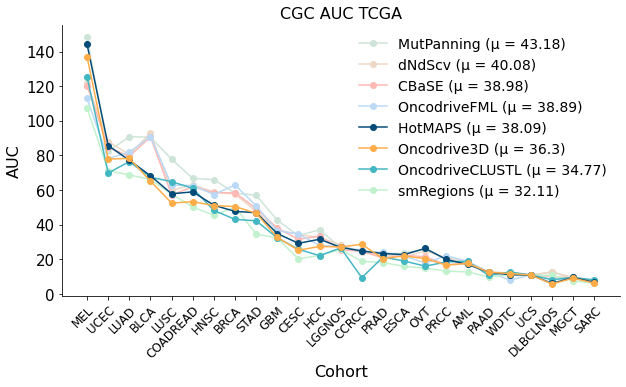

In [66]:
plot_auc_summary(df_auc_cgc, names_dict, colors_dict, 
                 title = "CGC AUC TCGA", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, plot_xticks = True, 
                 extract_cancer=True, legend_outside=True, 
                 filename="plots/cgc_auc_tcga.png")

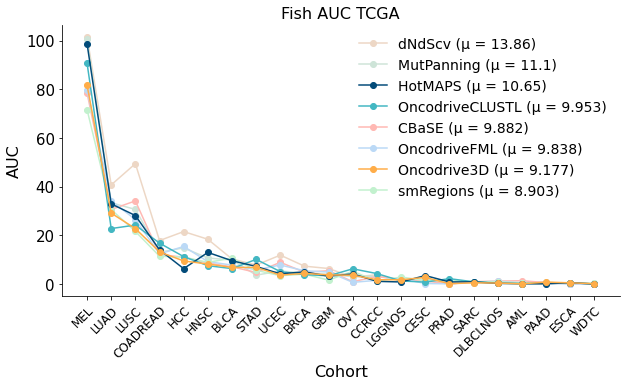

In [67]:
plot_auc_summary(df_auc_fish, names_dict, colors_dict, 
                 title = "Fish AUC TCGA", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, plot_xticks = True, 
                 extract_cancer=True, legend_outside=True, 
                 filename="plots/fishy_auc_tcga.png")

In [68]:
# All cohorts
df_auc = get_auc_genetable(genetable, 
                           lst_methods,
                           normalize=False, 
                           genes_overlap=True, 
                           min_rank_cut_thld=5,
                           processed_thld=1)

df_auc_cgc = df_auc[cols_to_plot(lst_methods, "CGC")]
df_auc_cgc = df_auc_cgc[~df_auc_cgc.isna().any(1)]
df_auc_fish = df_auc[cols_to_plot(lst_methods, "Fish")]
df_auc_fish = df_auc_fish[~df_auc_fish.isna().any(1)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:01<00:00, 79.90it/s]


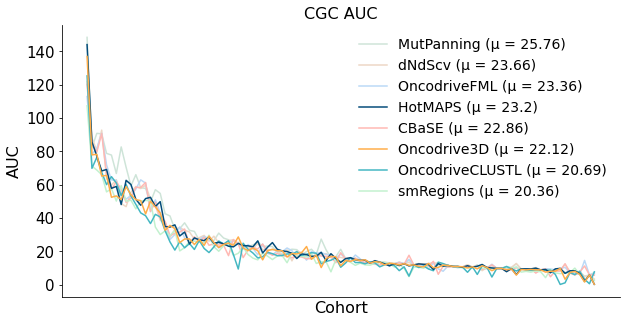

In [69]:
plot_auc_summary(df_auc_cgc, names_dict, colors_dict, title = "CGC AUC", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, 
                 plot_xticks = False, extract_cancer=False, legend_outside=True, style="-",
                 filename="plots/cgc_auc.png")

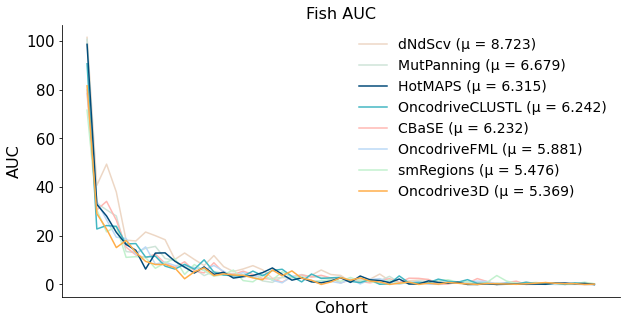

In [70]:
plot_auc_summary(df_auc_fish, names_dict, colors_dict, title = "Fish AUC", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, 
                 plot_xticks = False, extract_cancer=False, legend_outside=True, style="-",
                 filename="plots/fishy_auc.png")